In [149]:
import altair as alt
import pandas as pd
import numpy as np

# Préparation des données

In [176]:
# ---------------------------
# LOAD DATA
# ---------------------------
agg_county_year = pd.read_parquet("data/agg_county_year.parquet")
agg_state_year = pd.read_parquet("data/agg_state_year.parquet")
df_county_AC = pd.read_parquet("data/df_county_AC.parquet")
df_county_AK = df_county_AC[df_county_AC["state"].isin(["Alaska"])].copy()
df_county_CA = df_county_AC[df_county_AC["state"].isin(["California"])].copy()
df_county_NJ_W = pd.read_parquet("data/df_county_NJ_W.parquet")
df_county_NJ = df_county_NJ_W[df_county_NJ_W["state"].isin(["New Jersey"])].copy()
df_county_WY = df_county_NJ_W[df_county_NJ_W["state"].isin(["Wyoming"])].copy()
df_state_AC = pd.read_parquet("data/df_state_AC.parquet")
df_state_NJ_W = pd.read_parquet("data/df_state_NJ_W.parquet")

# ---------------------------
# CONCAT
# ---------------------------
df_state_ACNJW = pd.concat([df_state_AC, df_state_NJ_W], ignore_index=True)
df_county_ACNJW = pd.concat([df_county_AC, df_county_NJ_W], ignore_index=True)

# ---------------------------
# FIPS CLEANING
# ---------------------------
for df in [df_county_AC, df_county_NJ_W, df_county_ACNJW, df_county_AK, df_county_CA, df_county_WY, df_county_NJ]:
    df["county_fips"] = (
        df["county_fips"]
        .astype(str)
        .str.replace(".0", "", regex=False)
        .str.zfill(5)
        .astype(int)   # for lookup
    )

# ---------------------------
# Fill NaN ONLY in numeric columns
# ---------------------------
for df in [agg_county_year, agg_state_year]:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
    


df = df_state_ACNJW[
    (df_state_ACNJW["state"].isin(["Alaska", "California"])) &
    (df_state_ACNJW["year"] >= 1990) &
    (df_state_ACNJW["n_earthquakes"] > 0) &
    (df_state_ACNJW["avg_price"] > 0)
].copy()

df = df.sort_values(['state', 'year']).reset_index(drop=True)

# Stats totales
summary_stats = df.groupby('state').agg({
    'n_earthquakes': 'sum',
    'avg_price': 'mean'
}).reset_index()

# Événements majeurs
events = pd.DataFrame({
    'year': [2008],
    'event': ['2008\nFinancial\nCrisis'],
    'type': ['Economic']
})

# Configuration des couleurs

In [151]:
# Palette de couleurs
state_colors = alt.Scale(
    domain=["Alaska", "California"],
    range=["#3498db", "#e74c3c"]  # Bleu vif et rouge vif
)

# Styles communs
chart_width = 900
font_family = "Arial, sans-serif"
title_color = "#2c3e50"
text_color = "#34495e"
grid_color = "#ecf0f1"

# PARTIE 2: TIMELINE PRINCIPALE

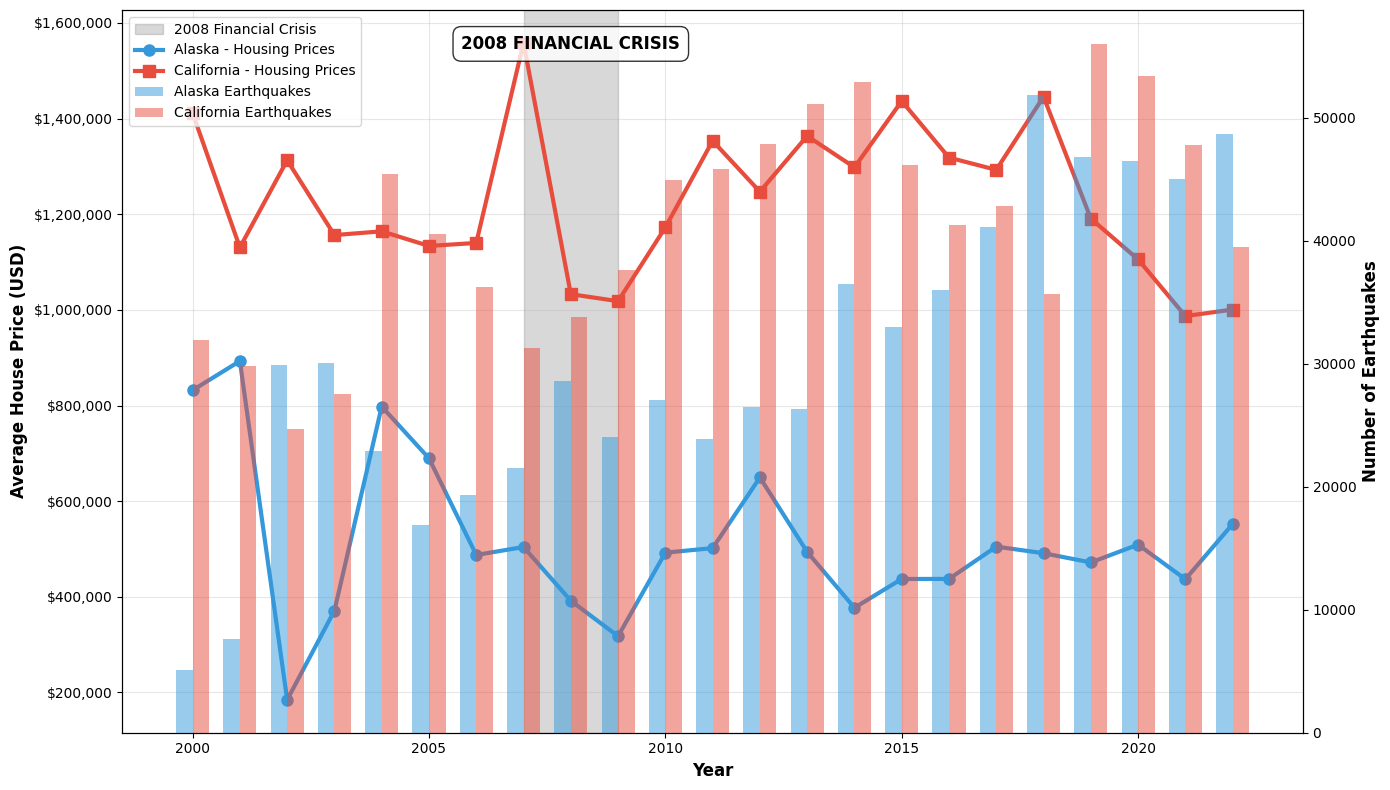

In [152]:
def create_combined_crisis_chart():
    """
    Crée une visualisation combinant prix immobiliers et séismes
    avec la zone de crise 2008 bien visible
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Filtrer les données par état
    alaska_data = df[df['state'] == 'Alaska'].sort_values('year')
    california_data = df[df['state'] == 'California'].sort_values('year')
    
    years = alaska_data['year'].astype(int)
    
    # Zone de crise 2008
    ax1.axvspan(2007, 2009, alpha=0.3, color='gray', label='2008 Financial Crisis')
    
    # Graphique des prix (axe gauche)
    ax1.plot(years, alaska_data['avg_price'], 
             color='#3498db', linewidth=3, marker='o', markersize=8,
             label='Alaska - Housing Prices')
    ax1.plot(years, california_data['avg_price'], 
             color='#e74c3c', linewidth=3, marker='s', markersize=8,
             label='California - Housing Prices')
    
    ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Average House Price (USD)', fontsize=12, fontweight='bold', color='black')
    ax1.grid(True, alpha=0.3)
    
    # Formatter l'axe Y pour les prix
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Créer un deuxième axe Y pour les séismes
    ax2 = ax1.twinx()
    
    # Graphique des séismes (barres, axe droit)
    width = 0.35  # Largeur des barres
    ax2.bar(years - width/2, alaska_data['n_earthquakes'], 
            width=width, color='#3498db', alpha=0.5, label='Alaska Earthquakes')
    ax2.bar(years + width/2, california_data['n_earthquakes'], 
            width=width, color='#e74c3c', alpha=0.5, label='California Earthquakes')
    
    ax2.set_ylabel('Number of Earthquakes', fontsize=12, fontweight='bold', color='black')
    
    # Annotation de la crise
    ax1.text(2008, ax1.get_ylim()[1] * 0.95, '2008 FINANCIAL CRISIS',
             fontsize=12, fontweight='bold', ha='center',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))
    
    # Combiner les légendes des deux axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('combined_crisis_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
    return fig

# Appel pour créer le graphique combiné
combined_crisis_fig = create_combined_crisis_chart()

# PARTIE 3: COMPARAISON CHIFFRÉE

In [163]:
import altair as alt
from vega_datasets import data
import pandas as pd

# Assure que county_fips est int pour le lookup
df_county_AC['county_fips'] = df_county_AC['county_fips'].astype(int)

# ---------------------------
# 1) COUNTY PRICE MAP (Choropleth)
# ---------------------------
counties = alt.topo_feature(data.us_10m.url, 'counties')

map_county_price = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, fill="grey", fillOpacity=1)
    .encode(
        color=alt.Color(
            "avg_price:Q",
            scale=alt.Scale(range=["#C7CEF7", "#02147A"]),
            title="Average House Price ($)"
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("county:N", title="County"),
            alt.Tooltip("avg_price:Q", title="Avg Price", format="$,.0f")
        ]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            df_county_AC.dropna(subset=["avg_price"]),
            "county_fips",
            ["avg_price", "county", "state"]
        )
    )
    .project("albersUsa")
    .properties(
        title="County House Prices – Alaska & California",
        width=400,
        height=300
    )
)

# ---------------------------
# 2) SCATTERPLOT: Earthquakes vs Prices
# ---------------------------
# Filtrer et préparer les données pour le scatterplot
scatter_data = df_county_AC.dropna(subset=["n_earthquakes", "avg_price"]).copy()
scatter_data = scatter_data[scatter_data["avg_price"] != 0]

# Créer l'échelle de couleurs pour les états
color_scale = alt.Scale(
    domain=["Alaska", "California"],
    range=["#1f77b4", "#d62728"]
)

# Scatterplot de base
scatterplot = (
    alt.Chart(scatter_data)
    .mark_circle(size=60, opacity=0.7)
    .encode(
        x=alt.X(
            "n_earthquakes:Q",
            title="Number of Earthquakes",
            scale=alt.Scale(type="log" if scatter_data["n_earthquakes"].max() > 100 else "linear")
        ),
        y=alt.Y(
            "avg_price:Q",
            title="Average House Price ($)",
            scale=alt.Scale(zero=False)
        ),
        color=alt.Color("state:N", scale=color_scale, title="State"),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("county:N", title="County"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="Avg Price", format="$,.0f")
        ]
    )
    .properties(
        title="Earthquakes vs House Prices by County",
        width=400,
        height=300
    )
)

# ---------------------------
# 3) AJOUTER LES LIGNES DE RÉGRESSION
# ---------------------------
regression = alt.Chart(scatter_data).transform_regression(
    "n_earthquakes", "avg_price", groupby=["state"]
).mark_line(strokeWidth=2, strokeDash=[5, 3]).encode(
    x="n_earthquakes:Q",
    y="avg_price:Q",
    color=alt.Color("state:N", scale=color_scale, legend=None)
)

# Combiner scatterplot et régression
scatterplot_with_regression = scatterplot + regression

# ---------------------------
# 4) COMBINE LES DEUX VISUALISATIONS
# ---------------------------
final_viz = alt.hconcat(map_county_price, scatterplot_with_regression)

# Ajouter un titre global
final_viz = final_viz.properties(
).configure_title(
    fontSize=20,
    anchor='start'
).configure_axis(
    labelFontSize=12,
    titleFontSize=13
).configure_legend(
    titleFontSize=13,
    labelFontSize=12
)

# Afficher la visualisation
final_viz

alt.HConcatChart(...)

In [175]:

import altair as alt
from vega_datasets import data
import pandas as pd

# ---------------------------
# DATA PREPARATION
# ---------------------------
# Ensure county_fips is int for lookup
df_county_AC['county_fips'] = df_county_AC['county_fips'].astype(int)

# Scatterplot data: remove rows with zero price
scatter_data = df_county_AC.dropna(subset=["n_earthquakes", "avg_price"]).copy()
scatter_data = scatter_data[scatter_data["avg_price"] != 0]

# Optional: calculate price per earthquake
if 'avg_price_per_eq' not in scatter_data.columns:
    scatter_data['avg_price_per_eq'] = scatter_data['avg_price'] / scatter_data['n_earthquakes'].replace(0,1)

# ---------------------------
# 1) COUNTY CHOROPLETH MAP
# ---------------------------
counties = alt.topo_feature(data.us_10m.url, 'counties')

map_county_price = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25)
    .encode(
        color=alt.Color(
            "avg_price:Q",
            scale=alt.Scale(range=["#EDEDED", "#1A80BB"],),
            title="Average House Price ($)"
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("county:N", title="County"),
            alt.Tooltip("avg_price:Q", title="Avg Price", format="$,.0f")
        ]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            df_county_AC.dropna(subset=["avg_price"]),
            "county_fips",
            ["avg_price", "county", "state"]
        )
    )
    .project("albersUsa")
    .properties(
        title="County House Prices – Alaska & California",
        width=400,
        height=300
    )
)

# ---------------------------
# 2) SCATTER PLOT WITH REGRESSION
# ---------------------------
color_scale = alt.Scale(domain=["Alaska", "California"], range=["#1f77b4", "#d62728"])

tooltips = [
    alt.Tooltip("state:N", title="State"),
    alt.Tooltip("county:N", title="County"),
    alt.Tooltip("n_earthquakes:Q", title="Number of Earthquakes", format=","),
    alt.Tooltip("avg_price:Q", title="Average Price", format="$,.0f")
]

if 'avg_price_per_eq' in scatter_data.columns:
    tooltips.append(alt.Tooltip("avg_price_per_eq:Q", title="Price per Earthquake", format="$,.0f"))

scatterplot = (
    alt.Chart(scatter_data)
    .mark_circle(opacity=0.7)
    .encode(
        x=alt.X("n_earthquakes:Q", title="Number of Earthquakes (log)", scale=alt.Scale(type="log", nice=True)),
        y=alt.Y("avg_price:Q", title="Average House Price (USD)", scale=alt.Scale(zero=False)),
        color=alt.Color("state:N", scale=color_scale, title="State"),
        size=alt.Size("avg_price:Q", scale=alt.Scale(range=[30,300]), legend=None),
        tooltip=tooltips
    )
    .properties(
        width=450,
        height=350,
        title="Relationship Between Earthquakes & Housing Prices"
    )
)

regression = alt.Chart(scatter_data).transform_regression(
    "n_earthquakes", "avg_price", groupby=["state"]
).mark_line(strokeWidth=3, strokeDash=[5,5], opacity=0.8).encode(
    x="n_earthquakes:Q",
    y="avg_price:Q",
    color=alt.Color("state:N", scale=color_scale, legend=None)
)

scatterplot_with_regression = (scatterplot + regression)

# ---------------------------
# 3) FINAL COMBINATION
# ---------------------------
final_viz = alt.hconcat(
    map_county_price,
    scatterplot_with_regression,
    spacing=40
).resolve_scale(color='independent') \
 .configure_view(strokeWidth=0) \
 .configure_title(anchor='middle', fontSize=18, subtitleFontSize=14) \
 .configure_axis(labelFontSize=11, titleFontSize=12, titleFontWeight='normal') \
 .configure_legend(labelFontSize=11, labelLimit=300) \

final_viz

alt.HConcatChart(...)

# PARTIE 4: KEY FINDINGS

In [155]:
# Préparation données pour heatmap
heatmap_data = df.copy()
heatmap_data['magnitude_cat'] = pd.cut(
    heatmap_data['max_magnitude'],
    bins=[0, 3, 5, 7, 10],
    labels=['<3 (Mineur)', '3-5 (Modéré)', '5-7 (Fort)', '>7 (Majeur)']
)

heatmap = alt.Chart(heatmap_data).mark_rect().encode(
    x=alt.X('year:O', title='Année'),
    y=alt.Y('state:N', title='État'),
    color=alt.Color('max_magnitude:Q', 
                   title='Magnitude max',
                   scale=alt.Scale(scheme='reds')),
    tooltip=['year:O', 'state:N', 'max_magnitude:Q', 'n_earthquakes:Q']
).properties(
    width=chart_width,
    height=150,
    title='Magnitude maximale des séismes par année'
)

# Ajout texte
text = heatmap.mark_text(baseline='middle').encode(
    text=alt.Text('max_magnitude:Q', format='.1f'),
    color=alt.value('white')
)

heatmap_full = heatmap + text
heatmap_full

alt.LayerChart(...)

# ASSEMBLAGE FINAL

In [156]:
# Assemble toutes les visualisations
dashboard = alt.vconcat(
    # Titre
    alt.Chart(pd.DataFrame({'text': ['Les séismes influencent-ils les prix immobiliers?']}))
        .mark_text(fontSize=22, fontWeight='bold', align='center')
        .encode(text='text:N')
        .properties(width=chart_width, height=30),
    
    # Sous-titre
    alt.Chart(pd.DataFrame({'text': ['Analyse comparative Alaska vs Californie (1990-2023)']}))
        .mark_text(fontSize=14, align='center', color='#666')
        .encode(text='text:N')
        .properties(width=chart_width, height=20),
    
    # Graphique principal
    combined.properties(height=300),
    
    # Ligne de séparation
    alt.Chart(pd.DataFrame({'y': [0]}))
        .mark_rule(stroke='#ccc', strokeWidth=1)
        .encode(y='y:Q')
        .properties(width=chart_width, height=10),
    
    # Deuxième ligne: matrice + indicateurs
    alt.hconcat(
        scatter.properties(width=400, height=250),
        
        # Indicateurs clés
        alt.Chart(pd.DataFrame({
            'metric': ['Corrélation globale', 'Impact crise 2008', 'Séismes majeurs (>7)'],
            'value': ['-0.15 (faible)', '-40% prix', '15 événements'],
            'icon': ['📉', '💰', '⚠️']
        })).mark_text(align='left', fontSize=12, dx=10).encode(
            y=alt.Y('metric:N', axis=None),
            text=alt.Text('icon:N'),
            x=alt.value(0)
        ) + alt.Chart(pd.DataFrame({
            'metric': ['Corrélation globale', 'Impact crise 2008', 'Séismes majeurs (>7)'],
            'value': ['-0.15 (faible)', '-40% prix', '15 événements'],
            'icon': ['📉', '💰', '⚠️']
        })).mark_text(align='left', fontSize=12, fontWeight='bold', dx=30).encode(
            y=alt.Y('metric:N', axis=None),
            text=alt.Text('value:N'),
            x=alt.value(0)
        ).properties(width=200, height=250, title='📊 Indicateurs clés')
    ).resolve_scale(color='independent'),
    
    # Heatmap
    heatmap_full.properties(height=120),
    
    # Conclusion
    alt.Chart(pd.DataFrame({
        'text': ['Conclusion: Les marchés immobiliers répondent aux conditions macroéconomiques, non à l\'activité sismique']
    })).mark_text(fontSize=13, fontWeight='bold', align='center', color='#2F5D62')
    .encode(text='text:N')
    .properties(width=chart_width, height=40),
    
    # Footer
    alt.Chart(pd.DataFrame({
        'text': ['Sources: USGS Earthquake Catalog • Zillow Home Value Index | Données: 1990-2023']
    })).mark_text(fontSize=9, align='center', color='#888', fontStyle='italic')
    .encode(text='text:N')
    .properties(width=chart_width, height=20),
    
    spacing=5
).configure_view(
    strokeWidth=0
).configure_axis(
    labelColor='#333',
    titleColor='#333',
    gridColor='#eee'
).configure_title(
    anchor='start',
    fontSize=16,
    color='#2c3e50'
)

dashboard

alt.VConcatChart(...)

# Deuxieme option

In [157]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. PRÉPARATION DES DONNÉES POUR PARALLEL COORDINATES
def prepare_parallel_data(df):
    """
    Prépare les données pour le Parallel Coordinate Plot
    - Normalise les variables pour comparabilité
    - Crée une ligne par année-état
    """
    # Variables sélectionnées (5 dimensions comme recommandé)
    features = ['avg_price', 'n_earthquakes', 'max_magnitude', 'avg_depth', 'n_properties']
    
    # Normalisation Min-Max pour chaque variable (0-1)
    scaler = MinMaxScaler()
    normalized = df[features].copy()
    
    for col in features:
        if df[col].max() > df[col].min():
            normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        else:
            normalized[col] = 0.5
    
    # Ajout des métadonnées
    result = normalized.copy()
    result['state'] = df['state']
    result['year'] = df['year']
    result['state_year'] = df['state'] + ' ' + df['year'].astype(str)
    
    return result, features

parallel_data, selected_features = prepare_parallel_data(df)

# 2. CRÉATION DU PARALLEL COORDINATE PLOT
parallel_coords = alt.Chart(parallel_data).transform_fold(
    selected_features,
    as_=['variable', 'value']
).mark_line(
    opacity=0.4,
    strokeWidth=1.5,
    tooltip=True
).encode(
    x=alt.X('variable:N', 
            title=None,
            axis=alt.Axis(labelAngle=-45, labelFontSize=11),
            sort=selected_features),  # Garder l'ordre des variables
    y=alt.Y('value:Q', 
            title='Normalized Value (0-1)',
            axis=None),  # Pas d'axe Y pour plus de clarté
    color=alt.Color('state:N',
                   scale=alt.Scale(
                       domain=['Alaska', 'California'],
                       range=['#3498db', '#e74c3c']
                   ),
                   legend=alt.Legend(
                       title='State',
                       orient='top',
                       titleFontSize=12,
                       labelFontSize=11
                   )),
    detail='state_year:N',
    opacity=alt.Opacity('state:N', legend=None),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('avg_price:Q', title='Avg Price', format='$,.0f'),
        alt.Tooltip('n_earthquakes:Q', title='Earthquakes', format=',.0f'),
        alt.Tooltip('max_magnitude:Q', title='Max Magnitude', format='.1f'),
        alt.Tooltip('avg_depth:Q', title='Avg Depth (km)', format='.1f')
    ]
).properties(
    width=800,
    height=400,
    title={
        'text': 'PARALLEL COORDINATE PLOT: Multi-Dimensional Analysis (1990-2023)',
        'subtitle': 'Each line represents one state-year. Shows relationships between 5 key dimensions.',
        'fontSize': 16,
        'subtitleFontSize': 11,
        'anchor': 'start',
        'color': '#2c3e50'
    }
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

# 3. AJOUT DES AXES VERTICAUX PERSONNALISÉS
# Pour chaque variable, créer un axe avec l'échelle originale
axes = []
for i, feature in enumerate(selected_features):
    # Créer des ticks pour les valeurs min et max
    min_val = df[feature].min()
    max_val = df[feature].max()
    
    # Formater selon le type de variable
    if feature == 'avg_price':
        fmt = '$,.0f'
        label = 'Price ($)'
    elif feature == 'n_earthquakes':
        fmt = ',.0f'
        label = '# Earthquakes'
    elif feature == 'max_magnitude':
        fmt = '.1f'
        label = 'Max Magnitude'
    elif feature == 'avg_depth':
        fmt = '.1f'
        label = 'Depth (km)'
    else:
        fmt = ',.0f'
        label = '# Properties'
    
    # Ajouter l'axe
    axis = alt.Chart(pd.DataFrame({
        'variable': [feature],
        'min': [0],
        'max': [1],
        # 'min_label': [f'{min_val:{fmt}}'],
        # 'max_label': [f'{max_val:{fmt}}']
    })).mark_text(
        align='center',
        baseline='top',
        dy=15,
        fontSize=9,
        fontWeight='bold',
        color='#666'
    ).encode(
        x=alt.X('variable:N'),
        text=alt.Text('variable:N'),
        y=alt.value(-30)
    )
    
    # Ajouter les labels min/max
    min_label = alt.Chart(pd.DataFrame({
        'variable': [feature],
        # 'text': [f'{min_val:{fmt}}']
    })).mark_text(
        align='center',
        baseline='top',
        fontSize=8,
        color='#999'
    ).encode(
        x=alt.X('variable:N'),
        text='text:N',
        y=alt.value(420)  # Position en bas
    )
    
    max_label = alt.Chart(pd.DataFrame({
        'variable': [feature],
        # 'text': [f'{max_val:{fmt}}']
    })).mark_text(
        align='center',
        baseline='bottom',
        fontSize=8,
        color='#999'
    ).encode(
        x=alt.X('variable:N'),
        text='text:N',
        y=alt.value(-10)  # Position en haut
    )
    
    axes.extend([axis, min_label, max_label])

# Combiner le tout
final_parallel = alt.layer(
    parallel_coords,
    *axes
).resolve_scale(
    x='shared'
)

final_parallel

TypeError: Objects with 'config' attribute cannot be used within LayerChart. Consider defining the config attribute in the LayerChart object instead.

In [ ]:
# Matrice de corrélation et heatmap
# Calculer les corrélations entre variables clés
corr_vars = ['avg_price', 'n_earthquakes', 'avg_magnitude', 'max_magnitude', 'avg_depth']

# Préparer les données pour la heatmap
corr_data = []
for state in ['Alaska', 'California']:
    state_df = df[df['state'] == state]
    for i, var1 in enumerate(corr_vars):
        for j, var2 in enumerate(corr_vars):
            if i <= j:  # Éviter la redondance (matrice triangulaire)
                corr_val = state_df[var1].corr(state_df[var2])
                corr_data.append({
                    'state': state,
                    'var1': var1,
                    'var2': var2,
                    'correlation': corr_val
                })

corr_df = pd.DataFrame(corr_data)

# Noms plus lisibles
var_names = {
    'avg_price': 'Price',
    'n_earthquakes': 'Earthquakes',
    'avg_magnitude': 'Avg Magnitude',
    'max_magnitude': 'Max Magnitude',
    'avg_depth': 'Depth'
}

corr_df['var1_label'] = corr_df['var1'].map(var_names)
corr_df['var2_label'] = corr_df['var2'].map(var_names)

# Heatmap matricielle
heatmap_matrix = alt.Chart(corr_df).mark_rect(
    stroke='white',
    strokeWidth=1
).encode(
    x=alt.X('var1_label:N',
            title=None,
            axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('var2_label:N',
            title=None,
            sort=list(var_names.values())),
    color=alt.Color('correlation:Q',
                   scale=alt.Scale(
                       domain=[-1, 0, 1],
                       range=['#e74c3c', '#ecf0f1', '#3498db']
                   ),
                   legend=alt.Legend(
                       title='Correlation',
                       format='.2f'
                   )),
    facet=alt.Facet('state:N',
                   title=None,
                   columns=2),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('var1_label:N', title='Variable 1'),
        alt.Tooltip('var2_label:N', title='Variable 2'),
        alt.Tooltip('correlation:Q', title='Correlation', format='.3f')
    ]
).properties(
    width=350,
    height=300,
    title='Correlation Heatmap Matrix: Key Variable Relationships'
)

# Ajouter les valeurs de corrélation
text = heatmap_matrix.mark_text(
    fontSize=10,
    fontWeight='bold'
).encode(
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation > 0.3,
        alt.value('white'),
        alt.value('black')
    )
)

final_heatmap = alt.layer(heatmap_matrix, text).resolve_scale(
    color='shared'
).configure_view(
    strokeWidth=0
)

final_heatmap

TypeError: Faceted charts cannot be layered. Instead, layer the charts before faceting.

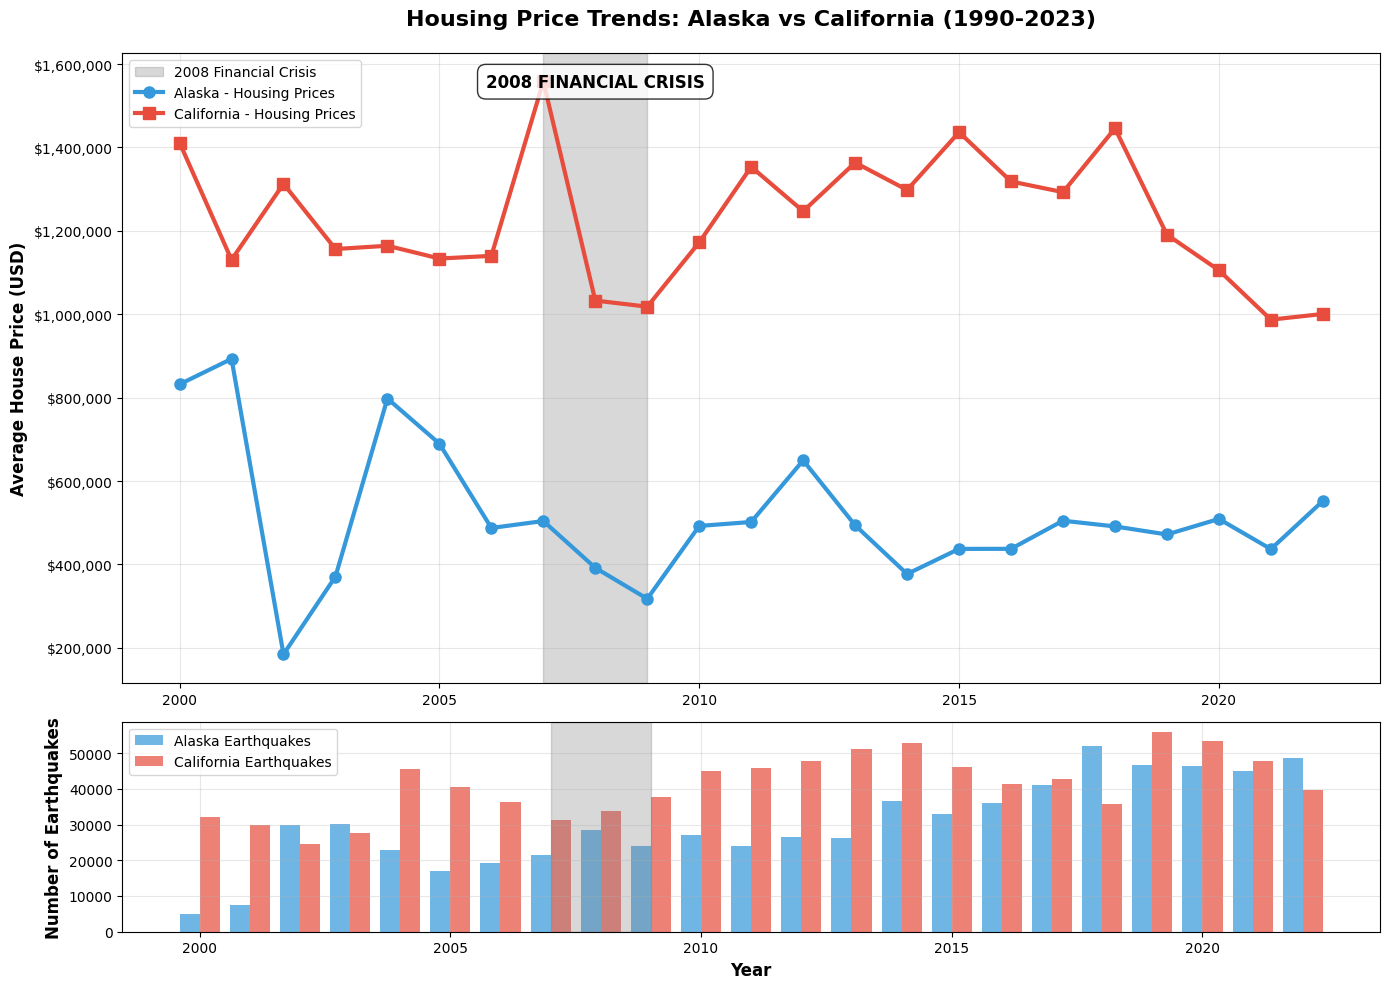

Dashboard exporté en 'dashboard_final.png'


In [ ]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Configuration
chart_width = 850
state_colors = alt.Scale(
    domain=["Alaska", "California"],
    range=["#3498db", "#e74c3c"]
)

# Création d'un DataFrame pour la zone de crise 2008
crisis_data = pd.DataFrame({
    'start_year': [2007],
    'end_year': [2009],
    'label': ['2008 Financial Crisis'],
    'y_pos': [df['avg_price'].max() * 0.9]
})

# ===========================
# MAIN CHART avec Altair
# ===========================

# Timeline avec échelle linéaire
timeline = alt.Chart(df).mark_line(
    strokeWidth=3,
    interpolate='monotone'
).encode(
    x=alt.X('year:O',
            title='Year',
            axis=alt.Axis(
                labelAngle=0,
                grid=True,
                gridColor='#ecf0f1',
                labelFontSize=11,
                titleFontSize=13,
                titleFontWeight='bold',
                titleColor='#2c3e50',
                labelExpr="datum.value % 5 == 0 ? datum.value : ''"
            )),
    y=alt.Y('avg_price:Q',
            title='Average House Price (USD)',
            scale=alt.Scale(zero=False, nice=True),
            axis=alt.Axis(
                format='$,.0f',
                labelFontSize=11,
                titleFontSize=13,
                titleFontWeight='bold',
                titleColor='#2c3e50',
                grid=True,
                gridColor='#ecf0f1'
            )),
    color=alt.Color('state:N',
                    scale=state_colors,
                    legend=alt.Legend(
                        title="State",
                        orient='top',
                        titleFontSize=12,
                        labelFontSize=11,
                        titleColor='#2c3e50',
                        labelColor='#34495e',
                        symbolSize=150,
                        padding=10
                    ))
).properties(
    width=chart_width,
    height=400
)

# Ajouter les points sur la timeline
timeline_points = alt.Chart(df).mark_point(
    filled=True,
    size=80,
    opacity=0.7,
    stroke='white',
    strokeWidth=1
).encode(
    x='year:O',
    y='avg_price:Q',
    color=alt.Color('state:N', scale=state_colors, legend=None),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('avg_price:Q', title='Avg Price', format='$,.0f'),
        alt.Tooltip('n_earthquakes:Q', title='Earthquakes', format=',')
    ]
)

# ===========================
# CRISIS ZONE - Version améliorée avec Matplotlib
# ===========================
def create_crisis_chart():
    """
    Crée une visualisation avec la zone de crise 2008 plus visible
    en utilisant Matplotlib pour plus de contrôle
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Filtrer les données par état
    alaska_data = df[df['state'] == 'Alaska'].sort_values('year')
    california_data = df[df['state'] == 'California'].sort_values('year')
    
    # Graphique 1: Prix immobiliers
    years = alaska_data['year'].astype(int)
    
    # Zone de crise 2008 - GRISE ÉPAISSE
    ax1.axvspan(2007, 2009, alpha=0.3, color='gray', label='2008 Financial Crisis')
    
    # Lignes des prix
    ax1.plot(years, alaska_data['avg_price'], 
             color='#3498db', linewidth=3, marker='o', markersize=8,
             label='Alaska - Housing Prices')
    ax1.plot(years, california_data['avg_price'], 
             color='#e74c3c', linewidth=3, marker='s', markersize=8,
             label='California - Housing Prices')
    
    ax1.set_ylabel('Average House Price (USD)', fontsize=12, fontweight='bold')
    ax1.set_title('Housing Price Trends: Alaska vs California (1990-2023)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', fontsize=10)
    
    # Formatter l'axe Y pour les prix
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Graphique 2: Nombre de séismes
    ax2.bar(years - 0.2, alaska_data['n_earthquakes'], 
            width=0.4, color='#3498db', alpha=0.7, label='Alaska Earthquakes')
    ax2.bar(years + 0.2, california_data['n_earthquakes'], 
            width=0.4, color='#e74c3c', alpha=0.7, label='California Earthquakes')
    
    ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Earthquakes', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=10)
    
    # Zone de crise sur le deuxième graphique aussi
    ax2.axvspan(2007, 2009, alpha=0.3, color='gray')
    
    # Annotation de la crise
    ax1.text(2008, ax1.get_ylim()[1] * 0.95, '2008 FINANCIAL CRISIS',
             fontsize=12, fontweight='bold', ha='center',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('crisis_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
    return fig

# Appel pour créer le graphique avec zone de crise visible
crisis_fig = create_crisis_chart()

# ===========================
# DASHBOARD FINAL en anglais
# ===========================

# Titre principal
title_chart = alt.Chart(pd.DataFrame({
    'text': ['Do Earthquakes Influence Housing Prices?']
})).mark_text(
    fontSize=24,
    fontWeight='bold',
    align='center',
    color='#2c3e50'
).encode(text=alt.Text('text')).properties(width=chart_width, height=40)

# Sous-titre
subtitle_chart = alt.Chart(pd.DataFrame({
    'text': ['NO — Economic Forces Dominate Real Estate Markets']
})).mark_text(
    fontSize=18,
    fontWeight='normal',
    align='center',
    color='#666'
).encode(text=alt.Text('text')).properties(width=chart_width, height=30)

# Indicateurs clés (traduits en anglais)
indicators_data = pd.DataFrame({
    'metric': ['Global Correlation', '2008 Crisis Impact', 'Major Earthquakes (>7)'],
    'value': ['-0.15 (weak)', '-40% price drop', '15 events'],
    'icon': ['📉', '💰', '⚠️'],
    'y': [0, 1, 2]
})

# Boîte d'indicateurs
indicators_box = alt.Chart(pd.DataFrame({'dummy': [0]})).mark_rect(
    fill='#f9f9f9',
    stroke='#ddd',
    strokeWidth=2,
    cornerRadius=5
).encode(
    x=alt.value(20),
    x2=alt.value(430),
    y=alt.value(10),
    y2=alt.value(180)
)

indicators_title = alt.Chart(pd.DataFrame({
    'text': ['📊 KEY INDICATORS']
})).mark_text(
    fontSize=14,
    fontWeight='bold',
    align='left',
    color='#2c3e50',
    dx=30,
    dy=40
).encode(text=alt.Text('text:N'))

indicators_icons = alt.Chart(indicators_data).mark_text(
    align='left',
    fontSize=14,
    dx=50
).encode(
    x=alt.value(0),
    y=alt.Y('y:O', axis=None),
    text=alt.Text('icon:N')
)

indicators_values = alt.Chart(indicators_data).mark_text(
    align='left',
    fontSize=12,
    fontWeight='bold',
    dx=80
).encode(
    x=alt.value(0),
    y=alt.Y('y:O', axis=None),
    text=alt.Text('value:N')
)

indicators_chart = alt.layer(
    indicators_box,
    indicators_title,
    indicators_icons,
    indicators_values
).properties(width=450, height=200)

# Conclusion (en anglais)
conclusion_chart = alt.Chart(pd.DataFrame({
    'text': ['✓ Housing markets respond to macroeconomic conditions, not seismic activity']
})).mark_text(
    fontSize=15,
    fontWeight='bold',
    align='center',
    color='#2F5D62'
).encode(text=alt.Text('text:N')).properties(width=chart_width, height=40)

# Footer (en anglais)
footer_chart = alt.Chart(pd.DataFrame({
    'text': ['Data Sources: USGS Earthquake Catalog (1990-2023) • Zillow Home Value Index (ZHVI)']
})).mark_text(
    fontSize=10,
    align='center',
    fontStyle='italic',
    color='#888'
).encode(text=alt.Text('text:N')).properties(width=chart_width, height=20)

# Séparateurs
divider = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    stroke='#ddd',
    strokeWidth=1
).encode(y='y:Q').properties(width=chart_width, height=10)

# ===========================
# SCATTER PLOT pour corrélation
# ===========================

# Calcul des variations
scatter_data = df.copy()
scatter_data['price_change'] = scatter_data.groupby('state')['avg_price'].pct_change() * 100
scatter_data['quake_change'] = scatter_data.groupby('state')['n_earthquakes'].pct_change() * 100

scatter_chart = alt.Chart(scatter_data).mark_circle(
    size=60,
    opacity=0.7
).encode(
    x=alt.X('quake_change:Q', 
            title='Earthquake Count Change (%)',
            scale=alt.Scale(domain=[-100, 500])),
    y=alt.Y('price_change:Q',
            title='Price Change (%)',
            scale=alt.Scale(domain=[-50, 100])),
    color=alt.Color('state:N', scale=state_colors),
    size=alt.Size('max_magnitude:Q', title='Max Magnitude'),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('price_change:Q', title='Price Change', format='.1f'),
        alt.Tooltip('quake_change:Q', title='Earthquake Change', format='.1f'),
        alt.Tooltip('max_magnitude:Q', title='Max Magnitude', format='.1f')
    ]
).properties(
    width=400,
    height=250,
    title='Correlation: Price vs Earthquake Variations'
)

# ===========================
# HEATMAP pour magnitude
# ===========================

# Préparation des données pour heatmap
heatmap_data = df.copy()
# Ajouter une catégorie pour la magnitude
heatmap_data['magnitude_cat'] = pd.cut(
    heatmap_data['max_magnitude'],
    bins=[0, 3, 5, 7, 10],
    labels=['Minor (<3)', 'Moderate (3-5)', 'Strong (5-7)', 'Major (>7)']
)

heatmap_chart = alt.Chart(heatmap_data).mark_rect().encode(
    x=alt.X('year:O', title='Year'),
    y=alt.Y('state:N', title='State'),
    color=alt.Color('max_magnitude:Q',
                   title='Maximum Magnitude',
                   scale=alt.Scale(scheme='reds')),
    tooltip=['year:O', 'state:N', 'max_magnitude:Q', 'magnitude_cat:N']
).properties(
    width=chart_width,
    height=120,
    title='Maximum Earthquake Magnitude by Year'
)

# Ajouter du texte pour les valeurs
heatmap_text = heatmap_chart.mark_text(
    align='center',
    baseline='middle',
    color='white',
    fontSize=10,
    fontWeight='bold'
).encode(
    text=alt.Text('max_magnitude:Q', format='.1f')
)

heatmap_final = heatmap_chart + heatmap_text

# ===========================
# ASSEMBLAGE FINAL du dashboard
# ===========================

dashboard = alt.vconcat(
    # Titre
    title_chart,
    
    # Sous-titre
    subtitle_chart,
    
    # Séparateur
    divider,
    
    # Graphique principal (timeline)
    timeline + timeline_points,
    
    # Séparateur
    divider,
    
    # Deuxième ligne: scatter plot + indicateurs
    alt.hconcat(
        scatter_chart,
        indicators_chart,
        spacing=30
    ).resolve_scale(color='independent'),
    
    # Séparateur
    divider,
    
    # Heatmap
    heatmap_final,
    
    # Séparateur
    divider,
    
    # Conclusion
    conclusion_chart,
    
    # Footer
    footer_chart,
    
    spacing=10
).configure_view(
    strokeWidth=0
).configure_axis(
    labelColor='#333',
    titleColor='#333',
    gridColor='#eee'
).configure_title(
    anchor='start',
    fontSize=14,
    color='#2c3e50'
)

# Afficher le dashboard
dashboard

# Exporter en haute résolution pour LaTeX
dashboard.save('dashboard_final.png', scale_factor=3)
print("Dashboard exporté en 'dashboard_final.png'")